In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import cv2
import joblib
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [ ]:
def load_images(image_folder):
    images = []
    labels = []
    class_names = sorted(os.listdir(image_folder))  # Đã sửa: Thêm `sorted`
    for label, class_name in enumerate(class_names):
        class_path = os.path.join(image_folder, class_name)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                images.append(img)
                labels.append(label)
    return np.array(images), np.array(labels), class_names

In [ ]:
def process_image(image, orientations, pixels_per_cell, cells_per_block, block_norm):
    return hog(
        image,
        orientations=orientations,
        pixels_per_cell=pixels_per_cell,
        cells_per_block=cells_per_block,
        block_norm=block_norm
    )

In [ ]:
def extract_hog_feature(images, orientations, pixels_per_cell, cells_per_block, block_norm):
    features = []
    for image in images:
        feature = process_image(image, orientations, pixels_per_cell, cells_per_block, block_norm)
        features.append(feature)
    return np.array(features)

In [ ]:
#Hàm huấn luyện model với GridSearch
def train_model_with_gridsearch(X_train, y_train, model, param_grid):
  grid_search = GridSearchCV(
      estimator = model,
      param_grid = param_grid,
      cv=5,
      scoring='accuracy',
      n_jobs=-1)
  grid_search.fit(X_train, y_train)
  return grid_search

In [ ]:
#Hàm đánh giá và in kết quả
def evaluate_model(model, X_test, y_test, class_names):
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, target_names=class_names)
    print("\nClassification Report:")
    print(report)
    return report

In [ ]:
#Lưu kết quả huấn luyện
def save_results(results_file, cv_results):
  with open(results_file, 'w') as f:
    for mean_score, params in zip(cv_results['mean_test_score'], cv_results['params']):
      line = f"Mean Accuracy: {mean_score:.6f}, Parameters: {params}"
      print(line)
      f.write(line + '\n')

In [ ]:
#Lưu model đã huấn luyện
def save_model(model, model_path, model_name):
    os.makedirs(model_path, exist_ok=True)
    model_file = os.path.join(model_path, model_name)
    joblib.dump(model, model_file)
    print(f"Model saved to {model_file}")
    return model_file

In [ ]:
#dataset_path = '/content/drive/My Drive/CS231/Dataset/'
dataset_path = '/content/drive/MyDrive/CS231_DT/Dataset'

train_folder = os.path.join(dataset_path, 'train')
X_train, y_train, class_names = load_images(train_folder)

test_folder = os.path.join(dataset_path, 'test')
X_test, y_test, _ = load_images(test_folder)

In [ ]:
orientations = 6
pixels_per_cell = (8, 8)
cells_per_block = (2, 2)
block_norm = 'L2-Hys'

In [ ]:
hog_train_feature = extract_hog_feature(X_train, orientations, pixels_per_cell, cells_per_block, block_norm)
hog_test_feature = extract_hog_feature(X_test, orientations, pixels_per_cell, cells_per_block, block_norm)

In [ ]:
hog_train_feature.shape

(992, 23064)

In [ ]:
model_path = '/content/drive/MyDrive/CS231_DT/Source_code/Model'
results_path = '/content/drive/MyDrive/CS231_DT/Source_code/Result'

In [ ]:
#Huấn luyện và đánh giá KNN
knn_params = {
    'n_neighbors': range(1, 15),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
    }

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

knn_grid = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=knn_params,
    scoring='accuracy',  # Có thể thay đổi scoring theo yêu cầu
    cv=cv,               # Chỉ định đối tượng cross-validation
    verbose=1
)

knn_grid.fit(hog_train_feature, y_train)

os.makedirs(results_path, exist_ok=True)
results_file = os.path.join(results_path, f'result_knn_6_8_2.txt')
save_results(results_file, knn_grid.cv_results_)

print("Best parameters for KNN:", knn_grid.best_params_)
print("Best KNN score:", knn_grid.best_score_)

evaluate_model(knn_grid.best_estimator_, hog_test_feature, y_test, class_names)

save_model(knn_grid.best_estimator_, model_path, f'knn_model_6_8_2.pkl')

Fitting 5 folds for each of 56 candidates, totalling 280 fits
Mean Accuracy: 0.934445, Parameters: {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}
Mean Accuracy: 0.934445, Parameters: {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'distance'}
Mean Accuracy: 0.931425, Parameters: {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'uniform'}
Mean Accuracy: 0.934445, Parameters: {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'}
Mean Accuracy: 0.915278, Parameters: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
Mean Accuracy: 0.914273, Parameters: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
Mean Accuracy: 0.929420, Parameters: {'metric': 'euclidean', 'n_neighbors': 4, 'weights': 'uniform'}
Mean Accuracy: 0.922349, Parameters: {'metric': 'euclidean', 'n_neighbors': 4, 'weights': 'distance'}
Mean Accuracy: 0.916304, Parameters: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'}
Mean Accuracy: 0.917299, 

'/content/drive/MyDrive/CS231_DT/Source_code/Model/knn_model_6_8_2.pkl'

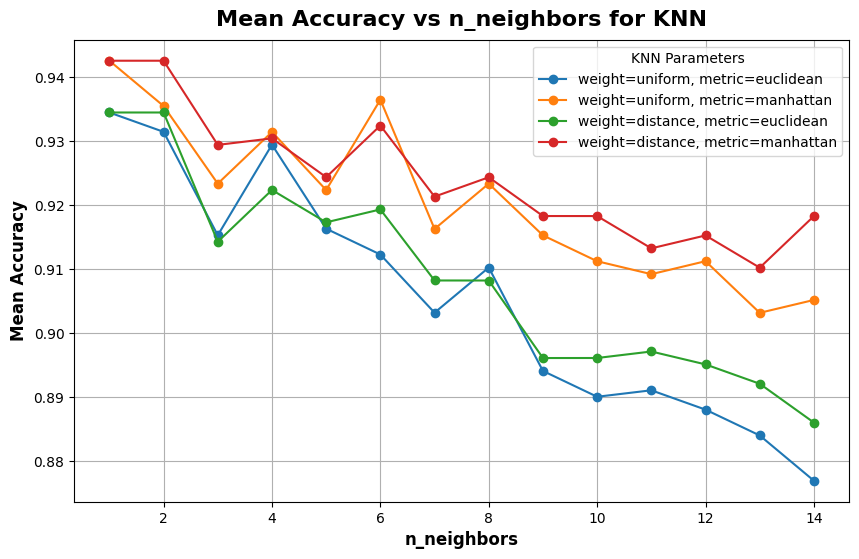

In [ ]:
def plot_knn_results(knn_grid):
    mean_accuracy = knn_grid.cv_results_['mean_test_score']
    n_neighbors = knn_grid.cv_results_['param_n_neighbors'].data
    weights = knn_grid.cv_results_['param_weights'].data
    metric = knn_grid.cv_results_['param_metric'].data

    plt.figure(figsize=(10, 6))

    for weight in ['uniform', 'distance']:
        for met in ['euclidean', 'manhattan']:
            mask = (weights == weight) & (metric == met)
            if np.any(mask):
                plt.plot(n_neighbors[mask], mean_accuracy[mask], marker='o', label=f'weight={weight}, metric={met}')

    plt.title('Mean Accuracy vs n_neighbors for KNN', fontsize=16, fontweight='bold', pad=10)
    plt.xlabel('n_neighbors', fontsize=12, fontweight='bold')
    plt.ylabel('Mean Accuracy', fontsize=12, fontweight='bold')
    plt.legend(title="KNN Parameters")
    plt.grid(True)
    plt.show()

plot_knn_results(knn_grid)

In [ ]:
#Huấn luyện và đánh giá bằng SVM
svm_params = {
    'kernel': ['linear', 'rbf', 'poly'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto']
}

# Khởi tạo StratifiedKFold để chia dữ liệu thành 5 folds (k=5)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

svm_grid = GridSearchCV(
    estimator=SVC(),
    param_grid=svm_params,
    scoring='accuracy',
    cv=cv,
    verbose=1
)

svm_grid.fit(hog_train_feature, y_train)

os.makedirs(results_path, exist_ok=True)
results_file = os.path.join(results_path, f'result_svm_6_8_2.txt')
save_results(results_file, svm_grid.cv_results_)

print("Best parameters for SVM:", svm_grid.best_params_)
print("Best SVM score:", svm_grid.best_score_)

evaluate_model(svm_grid.best_estimator_, hog_test_feature, y_test, class_names)

save_model(svm_grid.best_estimator_, model_path, f'svm_model_6_8_2.pkl')

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Mean Accuracy: 0.976798, Parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Mean Accuracy: 0.820522, Parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Mean Accuracy: 0.807421, Parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}
Mean Accuracy: 0.976798, Parameters: {'C': 0.1, 'gamma': 'auto', 'kernel': 'linear'}
Mean Accuracy: 0.271037, Parameters: {'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}
Mean Accuracy: 0.244866, Parameters: {'C': 0.1, 'gamma': 'auto', 'kernel': 'poly'}
Mean Accuracy: 0.976798, Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Mean Accuracy: 0.966712, Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Mean Accuracy: 0.953611, Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'poly'}
Mean Accuracy: 0.976798, Parameters: {'C': 1, 'gamma': 'auto', 'kernel': 'linear'}
Mean Accuracy: 0.814466, Parameters: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Mean Accuracy: 0.244866, 

'/content/drive/MyDrive/CS231_DT/Source_code/Model/svm_model_6_8_2.pkl'

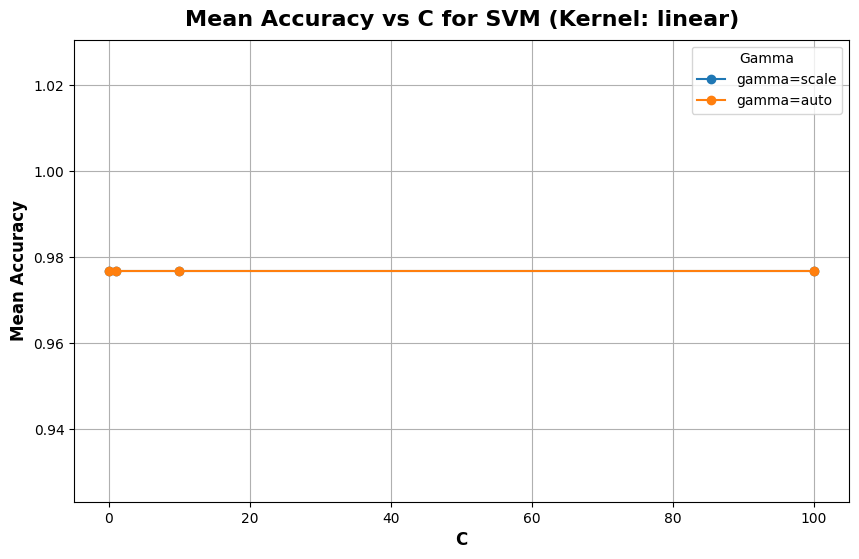

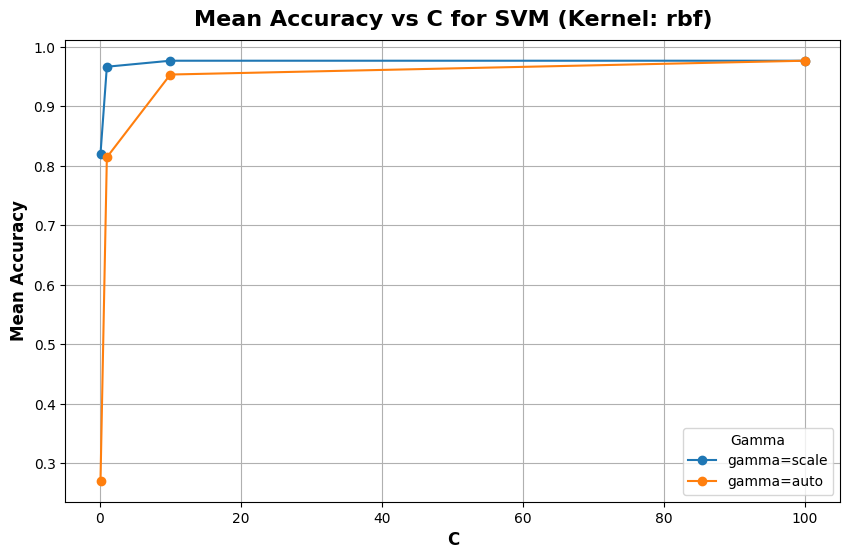

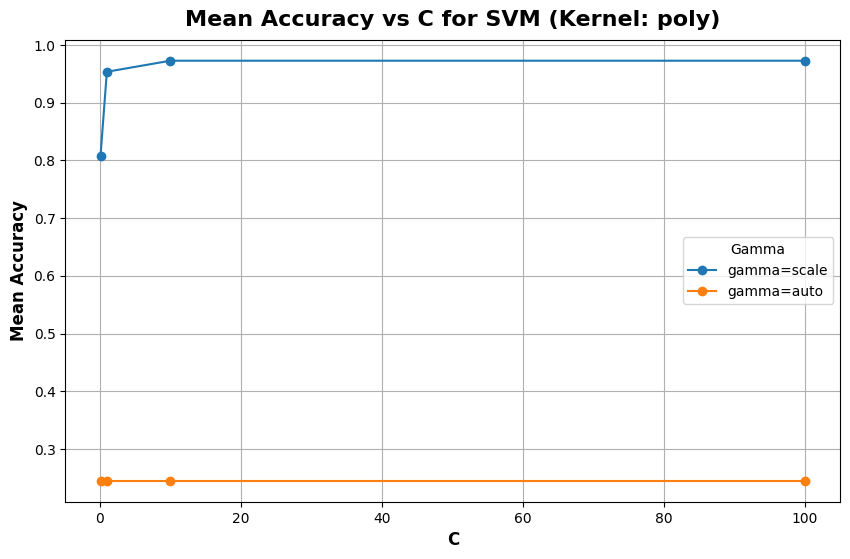

In [ ]:
def plot_svm_results(svm_grid):
    mean_accuracy = svm_grid.cv_results_['mean_test_score']
    kernel = svm_grid.cv_results_['param_kernel'].data
    C_values = svm_grid.cv_results_['param_C'].data
    gamma = svm_grid.cv_results_['param_gamma'].data

    kernels = ['linear', 'rbf', 'poly']

    for ker in kernels:
        plt.figure(figsize=(10, 6))
        for gam in ['scale', 'auto']:
            mask = (kernel == ker) & (gamma == gam)
            if np.any(mask):
                plt.plot(C_values[mask], mean_accuracy[mask], marker='o', label=f'gamma={gam}')

        plt.title(f'Mean Accuracy vs C for SVM (Kernel: {ker})', fontsize=16, fontweight='bold', pad=10)
        plt.xlabel('C', fontsize=12, fontweight='bold')
        plt.ylabel('Mean Accuracy', fontsize=12, fontweight='bold')
        plt.legend(title="Gamma")
        plt.grid(True)
        plt.show()

plot_svm_results(svm_grid)


In [ ]:
#Huấn luyện và đánh giá cho Random Forest
rf_params = {
    'n_estimators': [10, 50, 100, 150, 200, 250],
    'max_depth': [None, 10, 20, 30, 40, 50]
    }

rf_grid = train_model_with_gridsearch(
    X_train=hog_train_feature,
    y_train=y_train,
    model=RandomForestClassifier(),
    param_grid=rf_params)

os.makedirs(results_path, exist_ok=True)
results_file = os.path.join(results_path, f'result_rf_6_8_2.txt')
save_results(results_file, rf_grid.cv_results_)

print("Best parameters for RF:", rf_grid.best_params_)
print("Best RF score:", rf_grid.best_score_)

evaluate_model(rf_grid.best_estimator_, hog_test_feature, y_test, class_names)

save_model(rf_grid.best_estimator_, model_path, f'rf_model_6_8_2.pkl')

Mean Accuracy: 0.904228, Parameters: {'max_depth': None, 'n_estimators': 10}
Mean Accuracy: 0.939495, Parameters: {'max_depth': None, 'n_estimators': 50}
Mean Accuracy: 0.941511, Parameters: {'max_depth': None, 'n_estimators': 100}
Mean Accuracy: 0.940500, Parameters: {'max_depth': None, 'n_estimators': 150}
Mean Accuracy: 0.947556, Parameters: {'max_depth': None, 'n_estimators': 200}
Mean Accuracy: 0.942521, Parameters: {'max_depth': None, 'n_estimators': 250}
Mean Accuracy: 0.916283, Parameters: {'max_depth': 10, 'n_estimators': 10}
Mean Accuracy: 0.939490, Parameters: {'max_depth': 10, 'n_estimators': 50}
Mean Accuracy: 0.944531, Parameters: {'max_depth': 10, 'n_estimators': 100}
Mean Accuracy: 0.947556, Parameters: {'max_depth': 10, 'n_estimators': 150}
Mean Accuracy: 0.946561, Parameters: {'max_depth': 10, 'n_estimators': 200}
Mean Accuracy: 0.945536, Parameters: {'max_depth': 10, 'n_estimators': 250}
Mean Accuracy: 0.916324, Parameters: {'max_depth': 20, 'n_estimators': 10}
Mean 

'/content/drive/MyDrive/CS231_DT/Source_code/Model/rf_model_6_8_2.pkl'

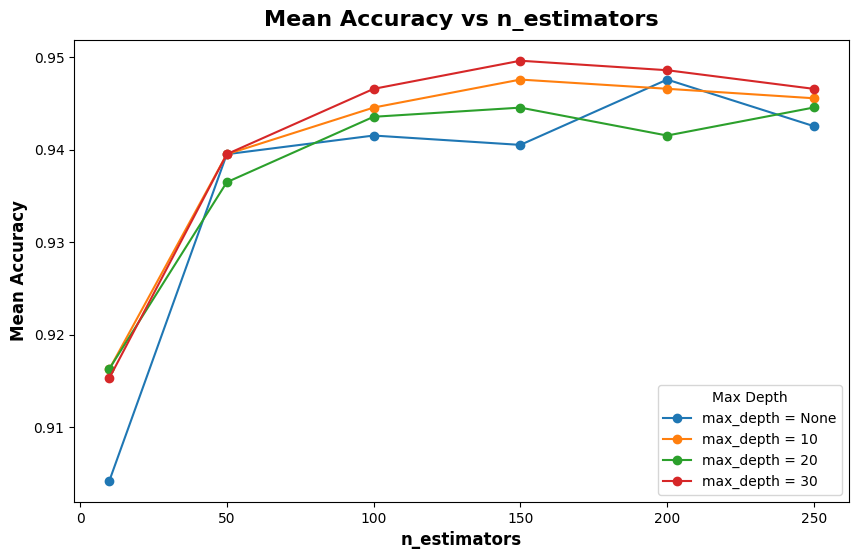

In [ ]:
# Trích xuất kết quả và tạo biểu đồ cho RF
def plot_rf():
    mean_accuracy = rf_grid.cv_results_['mean_test_score']
    n_estimators = rf_grid.cv_results_['param_n_estimators'].data
    max_depth = rf_grid.cv_results_['param_max_depth'].data

    plt.figure(figsize=(10, 6))

    mask = (max_depth == None)
    if np.any(mask):
        plt.plot(n_estimators[mask], mean_accuracy[mask], marker='o', label='max_depth = None')
    for depth in [10, 20, 30]:
        mask = (max_depth == depth)
        plt.plot(n_estimators[mask], mean_accuracy[mask], marker='o', label=f'max_depth = {depth}')

    plt.title('Mean Accuracy vs n_estimators', fontsize=16, fontweight='bold', pad=10)
    plt.xlabel('n_estimators', fontsize=12, fontweight='bold')
    plt.ylabel('Mean Accuracy', fontsize=12, fontweight='bold')
    plt.legend(title="Max Depth")
    plt.show()
plot_rf()